# Few Shot Prompting
In this notebook, we're going to see if we can get an LLM to determine if a sentence is a question or not with help from few-shot prompting.

In [196]:
!pip install llama_index openai python-dotenv termcolor mpu scikit-learn seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib!=3.6.1,>=3.3 from https://files.pythonhosted.org/packages/af/f3/fb27b3b902fc759bbca3f9d0336c48069c3022e57552c4b0095d997c7ea8/matplotlib-3.8.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/2c/8e/656f8e7cd316aa68d9824744773e90dbd71f847429d10c82001e927480a2/contourpy-1.1.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/49/ba/ebe5599acf47371393191091ae

## Our dataset 📋
We're going to attempt to categorise a bunch of sentences, some of which are questions and others which aren't.

In [255]:
import csv
from mpu.string import str2bool

with open('sentences.csv', 'r') as sentences_file:
  reader = csv.reader(sentences_file, delimiter=",")
  next(reader)
  sentences = [(row[0], str2bool(row[1])) for row in reader]

sentences

[('The weather is quite pleasant today.', False),
 ('Have you ever been to Paris', True),
 ('I enjoy reading books on rainy days.', False),
 ('What is your favorite type of cuisine', True),
 ('The movie last night was exhilarating.', False),
 ('She has a collection of vintage postcards.', False),
 ('Can you believe it’s already October', True),
 ('I think the library closes at 6 pm.', False),
 ('Where do you usually go for vacation', True),
 ('It’s amazing how time flies.', False),
 ('The concert last night was incredible.', False),
 ('Have you finished the report yet', True),
 ('He likes to play soccer on weekends.', False),
 ('What time does the meeting start', True),
 ("I can't believe how fast the kids are growing up.", False),
 ('Is the grocery store open on Sundays', True),
 ('She has a knack for solving complex puzzles.', False),
 ('Guess who just got promoted', True),
 ('The painting in the hallway is quite striking.', False),
 ('Could be that he forgot our appointment.', False

## Are they sentences? 🤔
Let's see whether our LLM can work out which ones are sentences!

In [256]:
from llama_index.llms import Ollama
import json
from termcolor import colored

In [257]:
def handle_result(sentence, is_sentence, llm_answer):
  result = f"Actual: {str(is_sentence).ljust(5)} LLM: {llm_answer}"
  print(f"{sentence.ljust(60)} {colored(result, 'green' if is_sentence == llm_answer else 'red')}")

def handle_error(sentence, is_sentence, ex, llm_says):
  result = f"Actual: {str(is_sentence).ljust(5)} LLM: {ex} - {llm_says}"
  print(f"{sentence.ljust(60)} {colored(result, 'red')}")

In [258]:
def predict_sentences(sentences, model):
  llm_answers=[]
  for sentence, is_sentence in sentences:
    llm_says = model.complete(sentence).text.replace("</s>", "").replace("<s>", "")
    try:
      llm_answer = json.loads(llm_says)
      handle_result(sentence, is_sentence, llm_answer)
      llm_answers.append(llm_answer)
    except json.JSONDecodeError as ex:
      handle_error(sentence, is_sentence, ex, llm_says)
      llm_answers.append(None)

  return llm_answers

In [259]:
base_llama2 = Ollama(model="question-llama2-base")

In [260]:
_ = predict_sentences(sentences, base_llama2)

ValueError: Ollama call failed with status code 400. Details: stat /Users/markhneedham/.ollama/models/manifests/registry.ollama.ai/library/question-llama2-base/latest: no such file or directory

## The Few-Shot Prompting Model 🤖
Let's try again, but this time with the model that's been primed with a few examples.

In [261]:
llama2 = Ollama(model="question-llama2")

In [262]:
llm_answers = predict_sentences(sentences, llama2)

ValueError: Ollama call failed with status code 400. Details: stat /Users/markhneedham/.ollama/models/manifests/registry.ollama.ai/library/question-llama2/latest: no such file or directory

## How well did we do? 🏆🤷‍♀️
Let's compute some metrics to check how well the model did.

In [263]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [264]:
# tp / (tp + fp) 
precision_score([s[1] for s in sentences], llm_answers, zero_division=0.0)

0.6666666666666666

In [265]:
# tp / (tp + fn)
recall_score([s[1] for s in sentences], llm_answers)

0.75

In [266]:
matrix = confusion_matrix([s[1] for s in sentences], llm_answers)
matrix

array([[9, 3],
       [2, 6]])

In [267]:
from plotly_utils import render_confusion_matrix

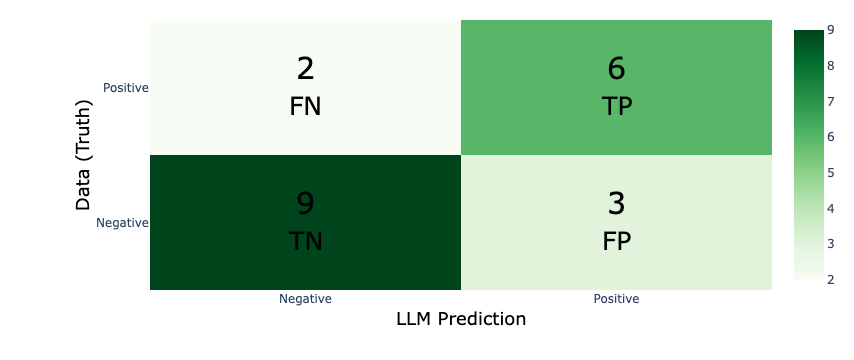

In [268]:
render_confusion_matrix(matrix)